# Setup

In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

# seed for reproducibility
torch.manual_seed(42)

device = torch.device("mps" if torch.mps.is_available() else "cpu")

root = '/Users/carivs/Documents/My space/Projects/sign-language/sign-language-digit-classification-vt'
data_dir = os.path.join(root, 'assets/asl_dataset')
# verify that the data is available
assert os.path.exists(data_dir), f"Data directory {data_dir} does not exist."

# Helpers

## Data preprocessor

In [2]:
class DataPreprocessor:
    def __init__(self,
                 data_dir: str,
                 transform: transforms.Compose=None,
                 input_shape: tuple[int,int]=(224, 224),
                 train_ratio: float=0.7,
                 val_ratio: float=0.15,
                 test_ratio: float=0.15,
                 batch_size: int=32):
        """
        Initialize the DataPreprocessor.

        Args:
            data_dir (str): Path to the dataset directory.
            transform (torchvision.transforms.Compose): Transformations to apply to the images.
            input_shape (tuple): Shape to resize the input images to.
            train_ratio (float): Proportion of data to use for training.
            val_ratio (float): Proportion of data to use for validation.
            test_ratio (float): Proportion of data to use for testing.
            batch_size (int): Batch size for DataLoader.
        """
        assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
        self.data_dir = data_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize(input_shape),
            transforms.ToTensor(),
            transforms.Normalize((0,),(1,))
        ])
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.batch_size = batch_size

    def preprocess(self):
        """
        Process the data into train, validation, and test splits.

        Returns:
            tuple: DataLoader objects for train, validation, and test sets.
        """
        # Load the entire dataset
        full_dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)
        
        # Compute dataset sizes
        total_size = len(full_dataset)
        train_size = int(self.train_ratio * total_size)
        val_size = int(self.val_ratio * total_size)
        test_size = total_size - train_size - val_size

        # Split the dataset indices
        indices = list(range(total_size))
        train_indices, temp_indices = train_test_split(indices, test_size=(val_size + test_size), random_state=42)
        val_indices, test_indices = train_test_split(temp_indices, test_size=test_size, random_state=42)

        # Create subsets
        train_dataset = Subset(full_dataset, train_indices)
        val_dataset = Subset(full_dataset, val_indices)
        test_dataset = Subset(full_dataset, test_indices)

        # Create DataLoaders
        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train, val, test

## CNN Sign language classifier model

In [3]:
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
            nn.Dropout(0.5),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [4]:
class SignLanguageTL:
    def __init__(self, model: nn.Module, weights, num_classes: int):
        """
        Initialize the ResNet model for fine-tuning.

        Args:
            num_classes (int): Number of output classes.
        """
        self.model = model(weights=weights)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the parameters of the last few layers for fine-tuning
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the fully connected layer
        in_features = self.model.fc.in_features
        # self.model.fc = nn.Linear(in_features, num_classes)
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 196),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(196, num_classes)
        )

## Transfer learning Sign language classifeer model

In [5]:
class SignLanguageModel:
    def __init__(self, model, save_path, device:torch.device=None):
        """
        Initialize the ResNet model for fine-tuning.

        Args:
            num_classes (int): Number of output classes.
        """
        self.device = device or torch.device("cpu")
        self.model = model.to(self.device)
        self.save_path = save_path

    def train(self, train, val, criterion, optimizer, epochs=10, save_best=False):
        """
        Train the model.

        Args:
            train (DataLoader): Training data loader.
            val (DataLoader): Validation data loader.
            epochs (int): Number of training epochs.
            lr (float): Learning rate.
        """
        # criterion = nn.CrossEntropyLoss()
        # optimizer = optim.Adam(self.model.parameters(), lr=lr)

        train_losses, val_losses = [], []
        best_val_loss = float('inf')  # Track the best validation accuracy
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            for inputs, labels in train:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                
            train_loss /= len(train)
            val_loss = self.evaluate(val, criterion, is_test=False)
            
            # Save losses
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
            
            if save_best and val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.save_path)
                print(f"New best model saved with loss: {best_val_loss:.4f}")

        if save_best:
            self.load_model()
        
        return train_losses, val_losses

    def evaluate(self, val, criterion=None, is_test=False):
        """
        Evaluate the model on validation data.

        Args:
            val (DataLoader): Validation data loader.
        """
        assert not is_test and criterion or is_test, "Criterion must be provided for evaluation."
        
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                if is_test:
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                else:
                    # loss = criterion(outputs, labels)
                    val_loss += criterion(outputs, labels).item()

        # print(f"Validation Accuracy: {100 * correct / total}%")
        return 100 * correct / total if is_test else val_loss / len(val)
    
    def load_model(self, path=None):
        """
        Load the model from a file. If no path is provided, the model is loaded from the save path.
        """
        path = path or self.save_path
        self.model.load_state_dict(torch.load(path))

# Execution

## Initialization

In [6]:
INPUT_SHAPE = (224, 224)
NB_CHANNELS = 3
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15
LR = 0.001
save_path = {
    'cnn': os.path.join(root, 'models/sign_language_cnn.pth'),
    'tl': os.path.join(root, 'models/sign_language_tl.pth'),
    'vt': os.path.join(root, 'models/sign_language_vf.pth'),
}

weights = models.ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

## Data preprocessing

In [7]:
data_preprocessor = DataPreprocessor(data_dir,
                                     transform=preprocess,
                                     input_shape=INPUT_SHAPE,
                                     train_ratio=TRAIN_RATIO,
                                     val_ratio=VAL_RATIO,
                                     test_ratio=TEST_RATIO)
train, val, test = data_preprocessor.preprocess()

# Print class names and sizes
classes = datasets.ImageFolder(data_dir).classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Train size: {len(train.dataset)}")
print(f"Validation size: {len(val.dataset)}")
print(f"Test size: {len(test.dataset)}")


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Train size: 1760
Validation size: 377
Test size: 378


## Training

In [8]:
# Initialize the model
model_type = 'tl'
model = SignLanguageCNN(num_classes=num_classes) if model_type == 'cnn' \
    else SignLanguageTL(models.resnet50, weights, num_classes=num_classes).model
trainer = SignLanguageModel(model, save_path=save_path[model_type], device=device)
criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=LR)
# optimizer = optim.SGD(model.parameters(), lr=LR*5, momentum=0.9)
# summary(model, (NB_CHANNELS, *INPUT_SHAPE))#, device=device.type)

In [9]:
# Train the model
train_losses, val_losses = trainer.train(train, val, criterion, optimizer, epochs=20, save_best=True)

Epoch 1/20, Train Loss: 1.9904, Val Loss: 0.5223
New best model saved with loss: 0.5223
Epoch 2/20, Train Loss: 0.4401, Val Loss: 0.3436
New best model saved with loss: 0.3436
Epoch 3/20, Train Loss: 0.2615, Val Loss: 0.5556
Epoch 4/20, Train Loss: 0.1798, Val Loss: 0.3272
New best model saved with loss: 0.3272
Epoch 5/20, Train Loss: 0.1202, Val Loss: 0.1753
New best model saved with loss: 0.1753
Epoch 6/20, Train Loss: 0.1068, Val Loss: 0.1504
New best model saved with loss: 0.1504
Epoch 7/20, Train Loss: 0.0489, Val Loss: 0.1728
Epoch 8/20, Train Loss: 0.0154, Val Loss: 0.0997
New best model saved with loss: 0.0997
Epoch 9/20, Train Loss: 0.0111, Val Loss: 0.1713
Epoch 10/20, Train Loss: 0.0278, Val Loss: 0.1266
Epoch 11/20, Train Loss: 0.0095, Val Loss: 0.0979
New best model saved with loss: 0.0979
Epoch 12/20, Train Loss: 0.0250, Val Loss: 0.2151
Epoch 13/20, Train Loss: 0.0426, Val Loss: 0.2228
Epoch 14/20, Train Loss: 0.0515, Val Loss: 0.1941
Epoch 15/20, Train Loss: 0.0493, Val

/var/folders/lh/z_xf3dnx7dggbs5y0wcp9zpc0000gn/T/ipykernel_35846/2328573041.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))

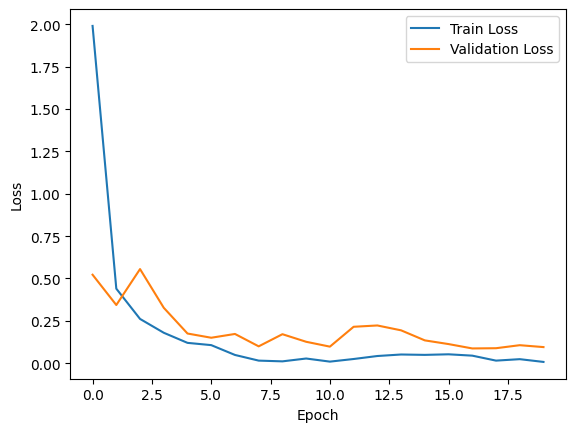

In [10]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

In [11]:
# Evaluate
trainer.evaluate(test, is_test=True)

97.35449735449735